In [16]:
import pandas as pd

# Reload the dataset
commodities_data = pd.read_csv('Dataset/all_commodities_data.csv')

# Ensure the date column is in datetime format and set as the index
gold_data = commodities_data[commodities_data['commodity'] == 'Gold']
gold_data['date'] = pd.to_datetime(gold_data['date'])
gold_data.set_index('date', inplace=True)

# Step 1: Data Transformation
# Resample to get monthly average prices
gold_data_monthly = gold_data['close'].resample('M').mean()

# Step 2: Rolling Forecast Setup
# Using the latest 60 months for validation and forecasting 3 months ahead
training_end = len(gold_data_monthly) - 63
validation_start = training_end + 1
validation_end = validation_start + 59  # 59 to include the starting point

train_data = gold_data_monthly[:training_end]
validation_data = gold_data_monthly[validation_start:validation_end]

# Displaying the start and end of training and validation data for verification
train_data.index[0], train_data.index[-1], validation_data.index[0], validation_data.index[-1]


C:\Users\zhizh\AppData\Local\Temp\ipykernel_11868\1731619659.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_data['date'] = pd.to_datetime(gold_data['date'])


(Timestamp('2000-08-31 00:00:00'),
 Timestamp('2018-07-31 00:00:00'),
 Timestamp('2018-09-30 00:00:00'),
 Timestamp('2023-07-31 00:00:00'))

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Separate the last 60 months for validation
train = gold_data_monthly[:-60]
validation = gold_data_monthly[-60:]

history = [x for x in train]
predictions_arima = []

# Rolling forecast
for t in range(0, 60, 3):  # Step size of 3 months
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=3)
    predictions_arima.extend(output)
    history.extend(validation[t:t+3])

# Compute the MSE for ARIMA on the validation set
mse_arima = mean_squared_error(validation[:len(predictions_arima)], predictions_arima)

mse_arima



6138.248619233464

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = [x for x in train]
predictions_sarima = []

# Rolling forecast for SARIMA
for t in range(0, 60, 3):
    model = SARIMAX(history, order=(5,1,0), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=3)
    predictions_sarima.extend(output)
    history.extend(validation[t:t+3])

# Compute the MSE for SARIMA on the validation set
mse_sarima = mean_squared_error(validation[:len(predictions_sarima)], predictions_sarima)

mse_sarima


6208.131122531319

In [52]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import numpy as np

import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
commodities_data = pd.read_csv('Dataset/all_commodities_data.csv')

# Preprocess the data
gold_data = commodities_data[commodities_data['commodity'] == 'Gold']
gold_data['date'] = pd.to_datetime(gold_data['date'])
gold_data.set_index('date', inplace=True)

# Resample to get monthly average prices
gold_data_monthly = gold_data['close'].resample('M').mean()

# Apply first-order differencing
gold_data_monthly_diff = gold_data_monthly.diff().dropna()

# Split the data into training and testing sets
train_size = int(len(gold_data_monthly_diff) - 3)
train, test = gold_data_monthly_diff[0:train_size], gold_data_monthly_diff[train_size:]

# Reshape and scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Create the LSTM dataset
X_train, y_train = train_scaled[:-1], train_scaled[1:]
X_test, y_test = test_scaled[:-1], test_scaled[1:]

# Since we need 3 predictions, we will adjust our X_test to include the necessary lags
X_test = np.append(X_test, np.zeros((1,1)), axis=0)

# Reshape data for LSTM [samples, timesteps, features]
X_train, X_test = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]), X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=200, verbose=0)

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling
predictions_inverted = scaler.inverse_transform(predictions)

# Revert the differencing
final_predictions = []
last_val = gold_data_monthly[train_size - 1]  # Get the last value before test data
for yhat in predictions_inverted:
    inverted = yhat + last_val
    final_predictions.append(inverted[0])
    last_val = inverted

# Calculate MSE
mse_ltsm = mean_squared_error(gold_data_monthly[train_size+1:], final_predictions)
print(f'MSE: {mse}')

# Calculating RMSE from the previously computed MSE
rmse = np.sqrt(mse_ltsm)
rmse

C:\Users\zhizh\AppData\Local\Temp\ipykernel_11868\2319752767.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_data['date'] = pd.to_datetime(gold_data['date'])


1/1 [==============================] - 0s 114ms/step
MSE: 1215.6824972481945


C:\Users\zhizh\AppData\Local\Temp\ipykernel_11868\2319752767.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_val = gold_data_monthly[train_size - 1]  # Get the last value before test data


35.0452639547808

In [53]:
# Load and preprocess the data
commodities_data = pd.read_csv('Dataset/all_commodities_data.csv')
gold_data = commodities_data[commodities_data['commodity'] == 'Gold']
gold_data['date'] = pd.to_datetime(gold_data['date'])
gold_data.set_index('date', inplace=True)
gold_data_monthly = gold_data['close'].resample('M').mean()

# Split the data into training and testing sets
train_size = int(len(gold_data_monthly) - 3)
train, test = gold_data_monthly[0:train_size], gold_data_monthly[train_size:]

# Fit ARIMA and SARIMA models and compute RMSE

# ARIMA
arima_model = ARIMA(train, order=(5,1,0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=3)

# SARIMA
sarima_model = SARIMAX(train, order=(5,1,0), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=3)

from sklearn.metrics import mean_squared_error

# Compute RMSE for ARIMA and SARIMA models
rmse_arima = mean_squared_error(test, arima_forecast, squared=False)
rmse_sarima = mean_squared_error(test, sarima_forecast, squared=False)

rmse_arima, rmse_sarima




C:\Users\zhizh\AppData\Local\Temp\ipykernel_11868\1308756142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_data['date'] = pd.to_datetime(gold_data['date'])


(65.69543675433347, 84.85923841704879)

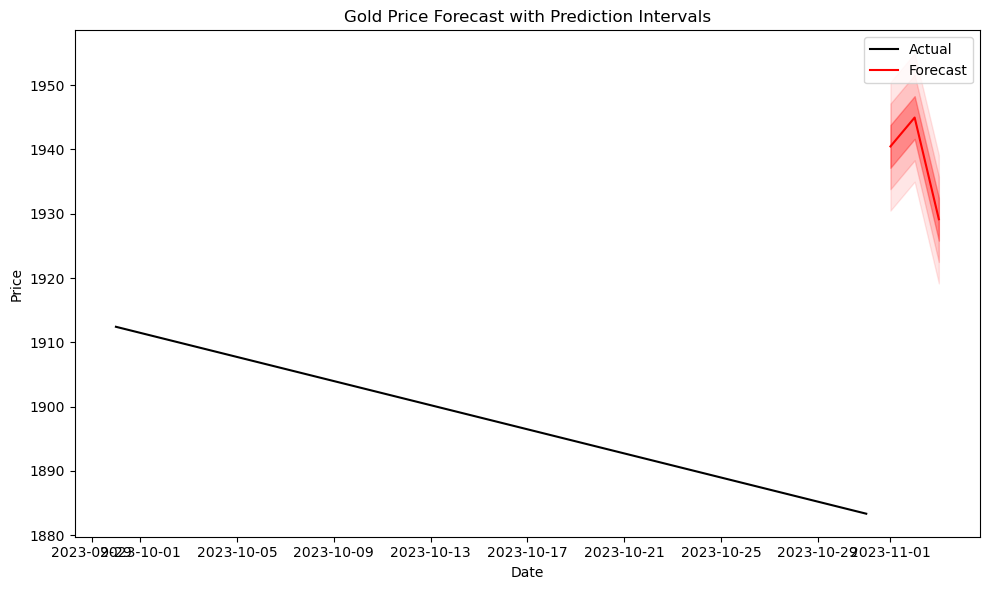

In [67]:
# Adjust the dates array to match the size of the forecast array
forecast_dates = pd.date_range(start=dates[-1], periods=len(forecast) + 1)[1:]

# Create the fan chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dates, actual, 'k', label='Actual')
ax.plot(forecast_dates, forecast, 'r', label='Forecast')
for i, interval in enumerate(intervals):
    ax.fill_between(forecast_dates, forecast - interval, forecast + interval, color='red', alpha=0.3/(i+1))

ax.set_title('Gold Price Forecast with Prediction Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
plt.tight_layout()
plt.show()
